# STA9131 Assignment 3-2: Convolutional Neural Networks and Batch Normalization

Before we start, please put your name, ID number, option (and your group members', if any) in following format: e.g., <br>
```
name = 'Kibok Lee'
idnum = '2022123456'
option = '1'
group = {
    '2022123457': 'Alice Ahn',
    '2022123458': 'Bob Bae',
    '2022123459': 'Carol Choi',
}
```

In [ ]:
# TODO: Put your name, id number, option (and your group members', if any):
# option 1 : You did your assignment yourself.
# option 2 : You didn't do your assignment yourself,
#            but you added your own comment to show your understanding.
# option 2L: You referred to LLMs, e.g., ChatGPT,
#            but you added your own comment to show your understanding,
#            and you submit a report (in pdf) with all your queries & outputs.
name = 'Your Name'
idnum = '2022123456'
option = '1'
group = {}

# Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

## Google Colab Setup
Next, we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine, you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Now, recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly, then running the following cell should print the filenames from the assignment:

```
['a3_helpers.py', 'assets', 'common', 'convolutional_networks.ipynb', 'convolutional_networks.py', 'fully_connected_networks.ipynb', 'fully_connected_networks.py']
```

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment.
# Example: If you create a STA9131 folder and put all the files under A3 folder, then 'STA9131/A3'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None

GOOGLE_DRIVE_PATH = os.path.join('/content/drive/MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(sorted(os.listdir(GOOGLE_DRIVE_PATH)))

Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from common!
Hello from convolutional_networks.py!
```

as well as the last edit time for the file `convolutional_networks.py`.

In [ ]:
import os
import sys
import time

sys.path.insert(0, GOOGLE_DRIVE_PATH)

os.environ["TZ"] = "Asia/Seoul"
time.tzset()

from common import hello as hello_common
hello_common()

from convolutional_networks import hello as hello_convolutional_networks
hello_convolutional_networks()

convolutional_networks_path = os.path.join(GOOGLE_DRIVE_PATH, 'convolutional_networks.py')
convolutional_networks_edit_time = time.ctime(os.path.getmtime(convolutional_networks_path))
print('convolutional_networks.py last edited on %s' % convolutional_networks_edit_time)

## Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [ ]:
import common
from common import reset_seed, Solver
from common.grad import compute_numeric_gradient, rel_error
import math
import torch
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'  # 'antialiased'
plt.rcParams['image.cmap'] = 'gray'  # viridis

We will use a GPU to accelerate our computation. Run the following cell to make sure you are using a GPU.
**Please confirm you are using Tesla T4**; if your GPU is not better than this, you might have some difficulty when training a good DeepConvNet.

In [ ]:
if torch.cuda.is_available():
    print('Good to go! You are using', torch.cuda.get_device_name())
    device = torch.device('cuda')
else:
    print('Please set GPU via Edit -> Notebook Settings.')
    device = torch.device('cpu')


# Define some common variables for dtypes/devices.
# These can be keyword arguments when defining new tensors.
to_float = {'dtype': torch.float32, 'device': device}
to_double = {'dtype': torch.float64, 'device': device}
to_long = {'dtype': torch.int64, 'device': device}

## Load CIFAR-10
We will first load the CIFAR-10 dataset. The utility function `common.data.preprocess_cifar10()` returns the entire CIFAR-10 dataset as a set of six **Torch tensors** while also preprocessing the RGB images:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

In [ ]:
# Invoke the above function to get our data.
import common

common.reset_seed(0)
data_dict = common.data.preprocess_cifar10(cuda=True, dtype=torch.float64,
                                           flatten=False)
print('Train data shape:', data_dict['X_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['X_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['X_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

# Convolutional networks
So far, we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient. But in practice, all state-of-the-art results use convolutional networks instead.

First, you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

## Convolutional layer
As in the previous notebook, we will package each new neural network operator in a class that defines a `forward` and `backward` function.

### Convolutional layer: forward
The core of a convolutional network is the convolution operation. **Implement** the `Conv.forward` function.

Note that learnable kernels do not have to be flipped, so your implementation should be technically cross-correlation for simplicity.

To be concrete, for arbitrary matrices $a \in \mathbb{R}^{H_a \times W_a}$ and $b \in \mathbb{R}^{H_b \times W_b}$, let $*$ be the cross-correlation satisfying
$$
(a * b)_{i, j} = \sum_{m=i}^{i+H_b-1}\sum_{n=j}^{j+W_b-1} a_{m, n} b_{m-i+1, n-j+1} = \sum_{p=1}^{H_b}\sum_{q=1}^{W_b} a_{i+p-1, j+q-1} b_{p, q}.
$$

Then, for
the input $x \in \mathbb{R}^{N \times C \times H \times W}$,
the kernel weights $w \in \mathbb{R}^{F \times C \times K_{H} \times K_{W}}$,
the bias $b \in \mathbb{R}^{F}$, and
the output $y \in \mathbb{R}^{N \times F \times H' \times W'}$
where
$H' = H - K_{H} + 1, W' = W - K_{W} + 1$,
$$
y_{n, f} = \sum_{c=1}^C x_{n, c} * w_{f, c} + b_{f} 1_{H' \times W'},
$$
where $1_{H' \times W'}$ is the $H' \times W'$ matrix with all one.

Note that the vectorized math for convolution/cross-correlation is somewhat complex and might not be useful for implementation; rather, recall that each output pixel is computed by the dot product between an input patch and kernel plus bias:
$$
y_{n, f, i, j} = \sum_{c=1}^C \sum_{p=1}^{K_{H}} \sum_{q=1}^{K_W} x_{n, c, i+p-1, j+q-1} w_{f, c, p, q} + b_{f}.
$$

**Note:** A naive implementation uses 4 nested for-loops to compute each element of the output, but you can vectorize along with the batch and channel dimensions to use only 2 nested for-loops, iterating over the height and width dimensions.
However, you don't have to worry too much about efficiency at this point; just write the code in whatever way you find the most clear.
You will get full credits as long as your implementation is correct.

After implementing the forward pass for the convolution operation, run the following to check your implementation. You should get an error less than `1e-7`.

In [ ]:
from convolutional_networks import Conv

x_shape = torch.tensor((2, 3, 4, 4))
w_shape = torch.tensor((3, 3, 4, 4))
x = torch.linspace(-0.1, 0.5, steps=torch.prod(x_shape), **to_double).reshape(*x_shape)
w = torch.linspace(-0.2, 0.3, steps=torch.prod(w_shape), **to_double).reshape(*w_shape)
b = torch.linspace(-0.1, 0.2, steps=3, **to_double)

conv_param = {'stride': 2, 'pad': 1}
out, _ = Conv.forward(x, w, b, conv_param)
correct_out = torch.tensor([[[[-0.08759809, -0.10987781],
                              [-0.18387192, -0.2109216 ]],
                             [[ 0.21027089,  0.21661097],
                              [ 0.22847626,  0.23004637]],
                             [[ 0.50813986,  0.54309974],
                              [ 0.64082444,  0.67101435]]],
                            [[[-0.98053589, -1.03143541],
                              [-1.19128892, -1.24695841]],
                             [[ 0.69108355,  0.66880383],
                              [ 0.59480972,  0.56776003]],
                             [[ 2.36270298,  2.36904306],
                              [ 2.38090835,  2.38247847]]]],
                          **to_double,
            )

print('Testing Conv.forward')
print('difference:', rel_error(out, correct_out))

### Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

In [ ]:
from imageio.v3 import imread
from PIL import Image
from torchvision.transforms import ToTensor

kitten_url = os.path.join(GOOGLE_DRIVE_PATH, 'assets/kitten.jpg')
puppy_url = os.path.join(GOOGLE_DRIVE_PATH, 'assets/puppy.jpg')

kitten = imread(kitten_url)
puppy = imread(puppy_url)
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = ToTensor()(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = ToTensor()(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = torch.stack([resized_puppy, resized_kitten])

# Set up a convolutional weights holding 2 filters, each 3x3
w = torch.zeros(2, 3, 3, 3, dtype=x.dtype)

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = torch.tensor([[0, 0, 0], [0, 0.3, 0], [0, 0, 0]])
w[0, 1, :, :] = torch.tensor([[0, 0, 0], [0, 0.6, 0], [0, 0, 0]])
w[0, 2, :, :] = torch.tensor([[0, 0, 0], [0, 0.1, 0], [0, 0, 0]])

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = torch.tensor([0, 128], dtype=x.dtype)

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = Conv.forward(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = img.max(), img.min()
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img)
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

### Convolutional layer: backward
**Implement** the `Conv.backward` function. Again, don't worry too much about computational efficiency.

To be concrete, the math is as follows:
$$
\frac{\partial L}{\partial x_{n, c}} = \sum_{f=1}^F w_{f, c} *_\text{full} \left(\frac{\partial L}{\partial y_{n, f}} \right),
$$
$$
\frac{\partial L}{\partial w_{f, c}} = \sum_{n=1}^N x_{n, c} * \left(\frac{\partial L}{\partial y_{n, f}}\right),
$$
$$
\frac{\partial L}{\partial b_{f}} = \sum_{n=1}^N \sum_{i=1}^{H'} \sum_{j=1}^{W'} \frac{\partial L}{\partial y_{n, f, i, j}},
$$
where $*_\text{full}$ is the full convolution, which applies the largest pad size, until no pixel is overlapped, such that $H = H' + K_{H} - 1, W = W' + K_{W} - 1$ hold.

Again, the vectorized math for convolution/cross-correlation might not be useful for implementation; rather, think about the gradient from each output pixel.

After implementing the backward pass for the convolution operation, run the following to check your implementation. You should get errors less than `1e-8`.

In [ ]:
from convolutional_networks import Conv

reset_seed(0)
x = torch.randn(4, 3, 5, 5, **to_double)
w = torch.randn(2, 3, 3, 3, **to_double)
b = torch.randn(2, **to_double)
dout = torch.randn(4, 2, 5, 5, **to_double)
conv_param = {'stride': 1, 'pad': 1}

dx_num = compute_numeric_gradient(lambda x: Conv.forward(x, w, b, conv_param)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Conv.forward(x, w, b, conv_param)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Conv.forward(x, w, b, conv_param)[0], b, dout)

out, cache = Conv.forward(x, w, b, conv_param)
dx, dw, db = Conv.backward(dout, cache)

print('Testing Conv.backward function')
print('dx error:', rel_error(dx, dx_num))
print('dw error:', rel_error(dw, dw_num))
print('db error:', rel_error(db, db_num))

## Max-pooling

### Max-pooling: forward
**Implement** the `MaxPool.forward` function. Again, don't worry too much about computational efficiency.

After implementing the forward pass for the max-pooling operation, run the following to check your implementation. You should get an error less than `1e-7`.


In [ ]:
from convolutional_networks import MaxPool

reset_seed(0)
x_shape = torch.tensor((2, 3, 4, 4))
x = torch.linspace(-0.3, 0.4, steps=torch.prod(x_shape), **to_double).reshape(*x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = MaxPool.forward(x, pool_param)

correct_out = torch.tensor([[[[-0.26315789, -0.24842105],
                              [-0.20421053, -0.18947368]],
                             [[-0.14526316, -0.13052632],
                              [-0.08631579, -0.07157895]],
                             [[-0.02736842, -0.01263158],
                              [ 0.03157895,  0.04631579]]],
                            [[[ 0.09052632,  0.10526316],
                              [ 0.14947368,  0.16421053]],
                             [[ 0.20842105,  0.22315789],
                              [ 0.26736842,  0.28210526]],
                             [[ 0.32631579,  0.34105263],
                              [ 0.38526316,  0.4       ]]]],
                           **to_double)

print('Testing MaxPool.forward function:')
print('difference:', rel_error(out, correct_out))

### Max-pooling: backward
**Implement** the `MaxPool.backward` function. Again, don't worry too much about computational efficiency.

After implementing the backward pass for the max-pooling operation, run the following to check your implementation. You should get an error less than `1e-9`.

In [ ]:
from convolutional_networks import MaxPool

reset_seed(0)
x = torch.randn(3, 2, 8, 8, **to_double)
dout = torch.randn(3, 2, 4, 4, **to_double)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = compute_numeric_gradient(lambda x: MaxPool.forward(x, pool_param)[0], x, dout)

out, cache = MaxPool.forward(x, pool_param)
dx = MaxPool.backward(dout, cache)

print('Testing MaxPool.backward function:')
print('dx error:', rel_error(dx, dx_num))

## Fast layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers. Those can be found at the bottom of `convolutional_networks.py`.

The fast convolution implementation depends on `torch.nn`.

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass receives upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**Note:** Together with the fast convolution and pooling layers, we also provide the APIs for `Linear` and `ReLU` layers that are exactly the same as those you implemented for the previous assignment, so that you don't have to implement the same functions multiple times. Those can be found at the bottom of `convolutional_networks.py`.

```python
class FastConv(object):

    @staticmethod
    def forward(x, w, b, conv_param):
        N, C, H, W = x.shape
        F, _, HH, WW = w.shape
        stride, pad = conv_param['stride'], conv_param['pad']
        layer = torch.nn.Conv2d(C, F, (HH, WW), stride=stride, padding=pad)
        layer.weight = torch.nn.Parameter(w)
        layer.bias = torch.nn.Parameter(b)
        tx = x.detach()
        tx.requires_grad = True
        out = layer(tx)
        cache = (x, w, b, conv_param, tx, out, layer)
        return out, cache

    @staticmethod
    def backward(dout, cache):
        try:
            x, _, _, _, tx, out, layer = cache
            out.backward(dout)
            dx = tx.grad.detach()
            dw = layer.weight.grad.detach()
            db = layer.bias.grad.detach()
            layer.weight.grad = layer.bias.grad = None
        except RuntimeError:
            dx, dw, db = torch.zeros_like(tx), torch.zeros_like(layer.weight), torch.zeros_like(layer.bias)
        return dx, dw, db


class FastMaxPool(object):

    @staticmethod
    def forward(x, pool_param):
        N, C, H, W = x.shape
        pool_height, pool_width = pool_param['pool_height'], pool_param['pool_width']
        stride = pool_param['stride']
        layer = torch.nn.MaxPool2d(kernel_size=(pool_height, pool_width), stride=stride)
        tx = x.detach()
        tx.requires_grad = True
        out = layer(tx)
        cache = (x, pool_param, tx, out, layer)
        return out, cache

    @staticmethod
    def backward(dout, cache):
        try:
            x, _, tx, out, layer = cache
            out.backward(dout)
            dx = tx.grad.detach()
        except RuntimeError:
            dx = torch.zeros_like(tx)
        return dx
```


We will now compare three different implementations of convolution (both forward and backward):

1. Your naive implementation on CPU
2. The fast implementation on CPU
3. The fast implementation on GPU

The differences between your implementation and `FastConv` should be less than `1e-10`. When moving from your implementation to `FastConv` CPU, you will likely see speedups of at least 100x. When comparing your implementation to `FastConv` CUDA, you will likely see speedups of more than 500x.

Note that these speedups are not hard requirements for this assignment, since we are not asking you to write any vectorized implementations.

In [ ]:
from convolutional_networks import Conv, FastConv

reset_seed(0)
x = torch.randn(10, 3, 31, 31, **to_double)
w = torch.randn(25, 3, 3, 3, **to_double)
b = torch.randn(25, **to_double)
dout = torch.randn(10, 25, 16, 16, **to_double)
x_cuda, w_cuda, b_cuda, dout_cuda = x.to('cuda'), w.to('cuda'), b.to('cuda'), dout.to('cuda')
conv_param = {'stride': 2, 'pad': 1}

t0 = time.time()
out_naive, cache_naive = Conv.forward(x, w, b, conv_param)
t1 = time.time()
out_fast, cache_fast = FastConv.forward(x, w, b, conv_param)
t2 = time.time()
out_fast_cuda, cache_fast_cuda = FastConv.forward(x_cuda, w_cuda, b_cuda, conv_param)
t3 = time.time()

print('Testing FastConv.forward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('Difference:', rel_error(out_naive, out_fast))
print('Difference CUDA:', rel_error(out_naive, out_fast_cuda.to(out_naive.device)))

t0 = time.time()
dx_naive, dw_naive, db_naive = Conv.backward(dout, cache_naive)
t1 = time.time()
dx_fast, dw_fast, db_fast = FastConv.backward(dout, cache_fast)
t2 = time.time()
dx_fast_cuda, dw_fast_cuda, db_fast_cuda = FastConv.backward(dout_cuda, cache_fast_cuda)
t3 = time.time()

print('\nTesting FastConv.backward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('dx difference:', rel_error(dx_naive, dx_fast))
print('dw difference:', rel_error(dw_naive, dw_fast))
print('db difference:', rel_error(db_naive, db_fast))
print('dx difference CUDA:', rel_error(dx_naive, dx_fast_cuda.to(dx_naive.device)))
print('dw difference CUDA:', rel_error(dw_naive, dw_fast_cuda.to(dw_naive.device)))
print('db difference CUDA:', rel_error(db_naive, db_fast_cuda.to(db_naive.device)))

We will now similarly compare your naive implementation of max pooling against the fast implementation. You should see differences of `0` between your implementation and the fast implementation.

When comparing your implementation against `FastMaxPool` on CPU, you will likely see speedups of more than 100x. When comparing your implementation against `FastMaxPool` on GPU, you will likely see speedups of more than 500x.

In [ ]:
from convolutional_networks import MaxPool, FastMaxPool

reset_seed(0)
x = torch.randn(40, 3, 32, 32, **to_double)
dout = torch.randn(40, 3, 16, 16, **to_double)
x_cuda, dout_cuda = x.to('cuda'), dout.to('cuda')
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time.time()
out_naive, cache_naive = MaxPool.forward(x, pool_param)
t1 = time.time()
out_fast, cache_fast = FastMaxPool.forward(x, pool_param)
t2 = time.time()
out_fast_cuda, cache_fast_cuda = FastMaxPool.forward(x_cuda, pool_param)
t3 = time.time()

print('Testing FastMaxPool.forward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('Difference:', rel_error(out_naive, out_fast))
print('Difference CUDA:', rel_error(out_naive, out_fast_cuda.to(out_naive.device)))

t0 = time.time()
dx_naive = MaxPool.backward(dout, cache_naive)
t1 = time.time()
dx_fast = FastMaxPool.backward(dout, cache_fast)
t2 = time.time()
dx_fast_cuda = FastMaxPool.backward(dout_cuda, cache_fast_cuda)
t3 = time.time()

print('\nTesting FastMaxPool.backward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('dx difference:', rel_error(dx_naive, dx_fast))
print('dx difference CUDA:', rel_error(dx_naive, dx_fast_cuda.to(dx_naive.device)))

## Convolutional "sandwich" layers
Previously, we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. Below you will find sandwich layers that implement a few commonly used patterns for convolutional networks. We've included them at the bottom of `covolutional_networks.py` Run the cells below to sanity check they're working.

```python
class Conv_ReLU(object):

    @staticmethod
    def forward(x, w, b, conv_param):
        """
        A convenience layer that performs a convolution followed by a ReLU.
        Inputs:
        - x: Input to the convolutional layer
        - w, b, conv_param: Weights and parameters for the convolutional layer
        Returns a tuple of:
        - out: Output from the ReLU
        - cache: Object to give to the backward pass
        """
        a, conv_cache = FastConv.forward(x, w, b, conv_param)
        out, relu_cache = ReLU.forward(a)
        cache = (conv_cache, relu_cache)
        return out, cache

    @staticmethod
    def backward(dout, cache):
        """
        Backward pass for the conv-relu convenience layer.
        """
        conv_cache, relu_cache = cache
        da = ReLU.backward(dout, relu_cache)
        dx, dw, db = FastConv.backward(da, conv_cache)
        return dx, dw, db


class Conv_ReLU_Pool(object):

    @staticmethod
    def forward(x, w, b, conv_param, pool_param):
        """
        A convenience layer that performs a convolution, a ReLU, and a pool.
        Inputs:
        - x: Input to the convolutional layer
        - w, b, conv_param: Weights and parameters for the convolutional layer
        - pool_param: Parameters for the pooling layer
        Returns a tuple of:
        - out: Output from the pooling layer
        - cache: Object to give to the backward pass
        """
        a, conv_cache = FastConv.forward(x, w, b, conv_param)
        s, relu_cache = ReLU.forward(a)
        out, pool_cache = FastMaxPool.forward(s, pool_param)
        cache = (conv_cache, relu_cache, pool_cache)
        return out, cache

    @staticmethod
    def backward(dout, cache):
        """
        Backward pass for the conv-relu-pool convenience layer
        """
        conv_cache, relu_cache, pool_cache = cache
        ds = FastMaxPool.backward(dout, pool_cache)
        da = ReLU.backward(ds, relu_cache)
        dx, dw, db = FastConv.backward(da, conv_cache)
        return dx, dw, db
```

Test the implementations of the sandwich layers by running the following. You should see errors less than `1e-7`.

In [ ]:
from convolutional_networks import Conv_ReLU, Conv_ReLU_Pool

reset_seed(0)

# Test Conv ReLU
x = torch.randn(2, 3, 8, 8, **to_double)
w = torch.randn(3, 3, 3, 3, **to_double)
b = torch.randn(3, **to_double)
dout = torch.randn(2, 3, 8, 8, **to_double)
conv_param = {'stride': 1, 'pad': 1}

out, cache = Conv_ReLU.forward(x, w, b, conv_param)
dx, dw, db = Conv_ReLU.backward(dout, cache)

dx_num = compute_numeric_gradient(lambda x: Conv_ReLU.forward(x, w, b, conv_param)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Conv_ReLU.forward(x, w, b, conv_param)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Conv_ReLU.forward(x, w, b, conv_param)[0], b, dout)

print('Testing Conv_ReLU:')
print('dx error:', rel_error(dx_num, dx))
print('dw error:', rel_error(dw_num, dw))
print('db error:', rel_error(db_num, db))

# Test Conv ReLU Pool
x = torch.randn(2, 3, 16, 16, **to_double)
w = torch.randn(3, 3, 3, 3, **to_double)
b = torch.randn(3, **to_double)
dout = torch.randn(2, 3, 8, 8, **to_double)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)
dx, dw, db = Conv_ReLU_Pool.backward(dout, cache)

dx_num = compute_numeric_gradient(lambda x: Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)[0], b, dout)

print()
print('Testing Conv_ReLU_Pool')
print('dx error:', rel_error(dx_num, dx))
print('dw error:', rel_error(dw_num, dw))
print('db error:', rel_error(db_num, db))

## Three-layer convolutional network
Now that you have implemented all the necessary layers, you can put them together into a simple convolutional network.

Complete the implementation of the `ThreeLayerConvNet` class. We **STRONGLY** recommend you to use the fast/sandwich layers (already implemented for you) in your implementation. Run the following cells to help you debug:

### Sanity check loss
After you build a new network, one of the things you should do first is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for a `C`-class classification task. When we add regularization, the loss should go up slightly.

In [ ]:
from convolutional_networks import ThreeLayerConvNet

reset_seed(0)
model = ThreeLayerConvNet(**to_double)

N = 50
X = torch.randn(N, 3, 32, 32, **to_double)
y = torch.randint(10, size=(N,), **to_long)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization):', loss.item())

model.reg = 1.
loss, grads = model.loss(X, y)
print('Initial loss (with regularization):', loss.item())

### Gradient check
After you confirm the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking, you should use a small amount of artificial data and a small number of neurons at each layer.

You should get errors less than `1e-5`.

In [ ]:
from convolutional_networks import ThreeLayerConvNet

num_inputs = 2
input_dims = (3, 16, 16)
reg = 0.
num_classes = 10
reset_seed(0)
X = torch.randn(num_inputs, *input_dims, **to_double)
y = torch.randint(num_classes, size=(num_inputs,), **to_long)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dims=input_dims, hidden_dim=7,
                          weight_scale=5e-2, **to_double)
loss, grads = model.loss(X, y)

for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = compute_numeric_gradient(f, model.params[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

### Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy (> 90%) and comparatively low validation accuracy.

In [ ]:
from convolutional_networks import ThreeLayerConvNet
from fully_connected_networks import adam

reset_seed(0)

num_train = 100
small_data = {
    'X_train': data_dict['X_train'][:num_train],
    'y_train': data_dict['y_train'][:num_train],
    'X_val': data_dict['X_val'],
    'y_val': data_dict['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-3,
                          **to_float)

solver = Solver(model, small_data,
                num_epochs=30, batch_size=50,
                update_rule=adam,
                optim_config={
                  'learning_rate': 2e-3,
                },
                verbose=True, print_every=1,
                device='cuda')
solver.train()

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

In [ ]:
plt.title('Training losses')
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

plt.title('Train and Val accuracies')
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

### Train the network
By training the three-layer convolutional network for one epoch, you should achieve greater than **50% accuracy** on the training set, and greater than **47% accuracy** on the validation set.

In [ ]:
from convolutional_networks import ThreeLayerConvNet
from fully_connected_networks import adam

reset_seed(0)

model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001,
                          **to_float)

solver = Solver(model, data_dict,
                num_epochs=1, batch_size=64,
                update_rule=adam,
                optim_config={
                  'learning_rate': 2e-3,
                },
                verbose=True, print_every=50, device='cuda')
solver.train()

### Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

In [ ]:
from torchvision.utils import make_grid
nrow = math.ceil(math.sqrt(model.params['W1'].shape[0]))
grid = make_grid(model.params['W1'], nrow=nrow, padding=1, normalize=True,
                 scale_each=True)
plt.imshow(grid.to(device='cpu').permute(1, 2, 0))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

## Deep convolutional network
Next, you will implement a deep convolutional network with an arbitrary number of conv layers in VGGNet style.

Read through the `DeepConvNet` class.

Implement the initialization, the forward pass, and the backward pass.
For the moment, don't worry about implementing batch normalization; we will add those features soon. Again, we **STRONGLY** recommend you to use the fast/sandwich layers (already implemented for you) in your implementation.

### Sanity check loss
After you build a new network, one of the things you should do first is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for a `C`-class classification task. When we add regularization, the loss should go up slightly.

In [ ]:
from convolutional_networks import DeepConvNet

reset_seed(0)
input_dims = (3, 32, 32)
model = DeepConvNet(num_filters=[8, 64], max_pools=[0, 1], **to_double)

N = 50
X = torch.randn(N, *input_dims, **to_double)
y = torch.randint(10, size=(N,), **to_long)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization):', loss.item())

model.reg = 2.
loss, grads = model.loss(X, y)
print('Initial loss (with regularization):', loss.item())

### Gradient check
After you confirm the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking, you should use a small amount of artificial data and a small number of neurons at each layer.

You should get errors less than `1e-5`.

In [ ]:
from convolutional_networks import DeepConvNet

reset_seed(0)
num_inputs = 2
input_dims = (3, 8, 8)
num_classes = 10
X = torch.randn(N, *input_dims, **to_double)
y = torch.randint(10, size=(N,), **to_long)

for reg in [0, 3.14]:
    print('Running check with reg =', reg)
    model = DeepConvNet(input_dims=input_dims, num_classes=num_classes,
                        num_filters=[8, 8, 8],
                        max_pools=[0, 2],
                        reg=reg,
                        weight_scale=5e-2, **to_double)

    loss, grads = model.loss(X, y)

    for param_name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = compute_numeric_gradient(f, model.params[param_name])
        print('%s max relative error: %e' % (param_name, rel_error(grad_num, grads[param_name])))
    if reg == 0: print()

### Overfit small data
As another sanity check, make sure you can overfit a small dataset of 50 images.
**Implement** `find_overfit_parameters` tweaking the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 30 epochs.

In [ ]:
# Use a DeepConvNet to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.
from convolutional_networks import DeepConvNet, find_overfit_parameters
from fully_connected_networks import adam

reset_seed(0)
num_train = 50
small_data = {
    'X_train': data_dict['X_train'][:num_train],
    'y_train': data_dict['y_train'][:num_train],
    'X_val': data_dict['X_val'],
    'y_val': data_dict['y_val'],
}
input_dims = small_data['X_train'].shape[1:]


# Update the parameters in find_overfit_parameters in convolutional_networks.py
weight_scale, learning_rate = find_overfit_parameters()


model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[8, 16, 32, 64],
                    max_pools=[0, 1, 2, 3],
                    reg=1e-5, weight_scale=weight_scale, **to_float)
solver = Solver(model, small_data,
                print_every=10, num_epochs=30, batch_size=10,
                update_rule=adam,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
# Turn off keep_best_params to allow final weights to be saved, instead of best weights on validation set.
solver.train(return_best_params=False)

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

train_acc = solver.check_accuracy(solver.X_train, solver.y_train, num_samples=solver.num_train_samples)
print('Training set accuracy:', train_acc)

If you're happy with the model's performance, run the following cell to save it.

We will also reload the model and run it on the training data to verify it's the right weights.

In [ ]:
path = os.path.join(GOOGLE_DRIVE_PATH, 'overfit_deepconvnet.pt')
solver.model.save(path)

# Create a new instance
model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[8, 16, 32, 64],
                    max_pools=[0, 1, 2, 3],
                    reg=1e-5, weight_scale=weight_scale, **to_float)
solver = Solver(model, small_data,
                print_every=10, num_epochs=30, batch_size=10,
                update_rule=adam,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )


# Load model
solver.model.load(path, **to_float)

# Evaluate on validation set
accuracy = solver.check_accuracy(small_data['X_train'], small_data['y_train'])
print(f"Saved model's accuracy on training is {accuracy}")

## Kaiming initialization
So far, you manually tuned the weight scale and for weight initialization.
However, this is inefficient when it comes to training deep neural networks; practically, as your weight matrix is larger, the weight scale should be small.
**Implement** `kaiming_initializer` for [Kaiming initialization](https://arxiv.org/abs/1502.01852). For more details, refer to [PyTorch documentation](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_).

After implementing the Kaiming initialization, run the following to check your implementation. You should get errors less than `1e-3`.

In [ ]:
from convolutional_networks import kaiming_initializer

reset_seed(0)

print('Kaiming init for Linear:')
w1 = kaiming_initializer(400, 2000, relu=False)
print('mean error:', w1.mean().abs().item())
print('std  error:', rel_error(w1.std(), torch.tensor(.05)))

print('\nKaiming init for Linear followed by ReLU:')
w2 = kaiming_initializer(200, 2000, relu=True)
print('mean error:', w2.mean().abs().item())
print('std  error:', rel_error(w2.std(), torch.tensor(.1)))

print('\nKaiming init for Conv:')
w3 = kaiming_initializer(100, 2000, 4, relu=False)
print('mean error:', w3.mean().abs().item())
print('std  error:', rel_error(w3.std(), torch.tensor(.025)))

print('\nKaiming init for Conv followed by ReLU:')
w4 = kaiming_initializer(200, 2000, 5, relu=True)
print('mean error:', w4.mean().abs().item())
print('std  error:', rel_error(w4.std(), torch.tensor(.02)))

### Convolutional networks with Kaiming initialization

Now that you have a working implementation for Kaiming initialization, go back to your `DeepConvnet`. Modify your implementation to add Kaiming initialization.

Concretely, when the `weight_scale` is set to `'kaiming'` in the constructor, you should initialize weights of convolutional and linear layers using `kaiming_initializer`. Once you are done, run the following to see the effect of kaiming initialization in deep CNNs.

In this experiment, we train a 31-layer network with four different weight initialization schemes. Among them, only the Kaiming initialization method should achieve a non-random accuracy after one epoch of training.

You may see a very high or even `nan` loss when `weight_scale` is large, this shows a catastrophe of inappropriate weight initialization.

In [ ]:
from convolutional_networks import DeepConvNet

reset_seed(0)

# Try training a deep convolutional net with different weight initialization methods
num_train = 10000
small_data = {
    'X_train': data_dict['X_train'][:num_train],
    'y_train': data_dict['y_train'][:num_train],
    'X_val': data_dict['X_val'],
    'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

weight_scales = ['kaiming', 1e-1, 1e-2, 1e-3]

solvers = []
for weight_scale in weight_scales:
    print('Solver with weight scale:', weight_scale)
    model = DeepConvNet(input_dims=input_dims, num_classes=10,
                        num_filters=([8] * 10) + ([32] * 10) + ([128] * 10),
                        max_pools=[9, 19],
                        weight_scale=weight_scale,
                        reg=1e-5,
                        **to_float
                        )

    solver = Solver(model, small_data,
                    num_epochs=1, batch_size=128,
                    optim_config={
                    'learning_rate': 2e-3,
                    },
                    print_every=20, device='cuda')
    solver.train()
    solvers.append(solver)

In [ ]:
def plot_training_history_init(title, xlabel, solvers, labels, plot_fn, marker='-o'):
    plt.title(title)
    plt.xlabel(xlabel)
    for solver, label in zip(solvers, labels):
        data = plot_fn(solver)
        label = 'weight_scale=' + str(label)
        plt.plot(data, marker, label=label)
    plt.legend(loc='lower center', ncol=len(solvers))
    if 'loss' in title:
        plt.ylim([2, 2.5])

plt.subplot(3, 1, 1)
plot_training_history_init('Training loss','Iteration', solvers, weight_scales,
                            lambda x: x.loss_history, marker='o')
plt.subplot(3, 1, 2)
plot_training_history_init('Training accuracy','Epoch', solvers, weight_scales,
                           lambda x: x.train_acc_history)
plt.subplot(3, 1, 3)
plot_training_history_init('Validation accuracy','Epoch', solvers, weight_scales,
                           lambda x: x.val_acc_history)
plt.gcf().set_size_inches(15, 25)
plt.show()

## Train a good model!
Train the best convolutional network that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least **71% accuracy** on the validation set using a convolutional net, within **30 seconds** of training. To make your model environmentally friendly, we limit the model size to less than **20MB**.

**Implement** `create_convolutional_solver_instance` while making sure to initialize your model with the input `dtype` and `device`, as well as initializing the solver on the input `device`.

**Hint 1:** While we do not limit the number of layers, your model does not have to be too deep. Three convolutional layers might be sufficient, and we could achieve 74% validation accuracy with the model size of less than **2MB**.

**Hint 2:** You might find it useful to use batch normalization, which is introduced later, but we could achieve 74% validation accuracy without batch normalization.

**Hint 3:** We used `batch_size = 128` for training a model with 74% validation accuracy. You don't have to follow this, but it would save your time for hyperparameter search.

**Hint 4:** Note that we import all the optimizers from `fully_connected_networks`, so feel free to use the optimizers you've already implemented; e.g., `adam`.

In [ ]:
from convolutional_networks import DeepConvNet, create_convolutional_solver_instance

torch.backends.cudnn.deterministic = True
reset_seed(0)

solver = create_convolutional_solver_instance(data_dict, **to_float)

solver.train(time_limit=30)

## Test your model!
Run your best model on the validation and test sets. You should achieve at least **71% accuracy** on the validation set and **70% accuracy** on the test set.

(Our best model gets 74.3% validation accuracy and 73.5% test accuracy -- can you beat ours?)


In [ ]:
print('Validation set accuracy:', solver.check_accuracy(data_dict['X_val'], data_dict['y_val']))
print('Test set accuracy:', solver.check_accuracy(data_dict['X_test'], data_dict['y_test']))

If you're happy with the model's performance, run the following cell to save it.
Make sure your model size is less than **20MB**.

We will also reload the model and run it on the training data to verify it's the right weights.

In [ ]:
path = os.path.join(GOOGLE_DRIVE_PATH, 'half_minute_deepconvnet.pt')
solver.model.save(path)

# Create a new instance
from convolutional_networks import DeepConvNet, create_convolutional_solver_instance

solver = create_convolutional_solver_instance(data_dict, **to_float)

# Load model
solver.model.load(path, **to_float)

# Evaluate on validation set
print('Validation set accuracy:', solver.check_accuracy(data_dict['X_val'], data_dict['y_val']))
print('Test set accuracy:', solver.check_accuracy(data_dict['X_test'], data_dict['y_test']))

# Batch Normalization
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train.
One idea along these lines is batch normalization which was proposed by [1] in 2015.

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However, even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [1] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

## Batch normalization: forward
Implement the batch normalization forward pass in the function `BatchNorm.forward`. Once you have done so, run the following to test your implementation.

Referencing the paper linked to above in [1] may be helpful!

After implementing the forward pass for batch normalization, you can run the following to sanity check your implementation. After running batch normalization with `beta=0` and `gamma=1`, the data should have approximately zero mean and unit variance; difference should be around `1e-1` or less.

After running batch normalization with nontrivial `beta` and `gamma`, the output data should have mean approximately equal to `beta`, and std approximatly equal to `gamma`.

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization
from convolutional_networks import BatchNorm

def print_mean_std(x,dim=0):
    means = ['%.3f' % xx for xx in x.mean(dim=dim).tolist()]
    stds = ['%.3f' % xx for xx in x.std(dim=dim).tolist()]
    print('  Means:', means)
    print('  Stds :', stds)
    print()

# Simulate the forward pass for a two-layer network
reset_seed(0)
N, D1, D2, D3 = 200, 50, 60, 3
X = torch.randn(N, D1, **to_double)
W1 = torch.randn(D1, D2, **to_double)
W2 = torch.randn(D2, D3, **to_double)
a = X.matmul(W1).clamp(min=0.).matmul(W2)

print('Before batch normalization:')
print_mean_std(a,dim=0)

# Run with gamma=1, beta=0. Means should be close to zero and stds close to one
gamma = torch.ones(D3, **to_double)
beta = torch.zeros(D3, **to_double)
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = BatchNorm.forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,dim=0)

# Run again with nontrivial gamma and beta. Now means should be close to beta
# and std should be close to gamma.
gamma = torch.tensor([1.0, 2.0, 3.0], **to_double)
beta = torch.tensor([11.0, 12.0, 13.0], **to_double)
print('After batch normalization (gamma=', gamma.tolist(), ', beta=', beta.tolist(), ')')
a_norm, _ = BatchNorm.forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,dim=0)

We can sanity-check the test-time forward pass of batch normalization by running the following. First we run the training-time forward pass many times to "warm up" the running averages. If we then run a test-time forward pass, the output should have approximately zero mean and unit variance; difference should be around `1e-1` or less.

In [ ]:
from convolutional_networks import BatchNorm

reset_seed(0)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = torch.randn(D1, D2, **to_double)
W2 = torch.randn(D2, D3, **to_double)

bn_param = {'mode': 'train'}
gamma = torch.ones(D3, **to_double)
beta = torch.zeros(D3, **to_double)

for t in range(500):
    X = torch.randn(N, D1, **to_double)
    a = X.matmul(W1).clamp(min=0.).matmul(W2)
    BatchNorm.forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = torch.randn(N, D1, **to_double)
a = X.matmul(W1).clamp(min=0.).matmul(W2)
a_norm, _ = BatchNorm.forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,dim=0)

## Batch normalization: backward
Now implement the backward pass for batch normalization in the function `BatchNorm.backward`.

To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass.

**Don't forget to implement the train and test mode separately.**

Once you have finished, run the following to numerically check your backward pass. You should get errors less than `1e-7`.

In [ ]:
from convolutional_networks import BatchNorm

# Gradient check batchnorm backward pass
reset_seed(0)
N, D = 4, 5
x = 5 * torch.randn(N, D, **to_double) + 12
gamma = torch.randn(D, **to_double)
beta = torch.randn(D, **to_double)
dout = torch.randn(N, D, **to_double)

bn_param = {'mode': 'train'}
fx = lambda x: BatchNorm.forward(x, gamma, beta, bn_param)[0]
fg = lambda a: BatchNorm.forward(x, a, beta, bn_param)[0]
fb = lambda b: BatchNorm.forward(x, gamma, b, bn_param)[0]

dx_num = compute_numeric_gradient(fx, x, dout)
da_num = compute_numeric_gradient(fg, gamma.clone(), dout)
db_num = compute_numeric_gradient(fb, beta.clone(), dout)

_, cache = BatchNorm.forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = BatchNorm.backward(dout, cache)

print('dx error:', rel_error(dx_num, dx))
print('dgamma error:', rel_error(da_num, dgamma))
print('dbeta error:', rel_error(db_num, dbeta))

## (Challenge Question) Batch Normalization: alternative backward
In the lecture on backpropagation, we talked about two different implementations for the sigmoid backward pass. One strategy is to write out a computation graph composed of simple operations and backprop through all intermediate values. Another strategy is to work out the derivatives on paper. For example, you can derive a very simple formula for the sigmoid function's backward pass by simplifying gradients on paper.

Surprisingly, it turns out that you can do a similar simplification for the batch normalization backward pass too!

In the forward pass, given a set of inputs $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$,

we first calculate the mean $\mu$ and variance $v$.
With $\mu$ and $v$ calculated, we can calculate the standard deviation $\sigma$  and normalized data $Y$.
The equations and graph illustration below describe the computation ($y_i$ is the i-th element of the vector $Y$).

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}

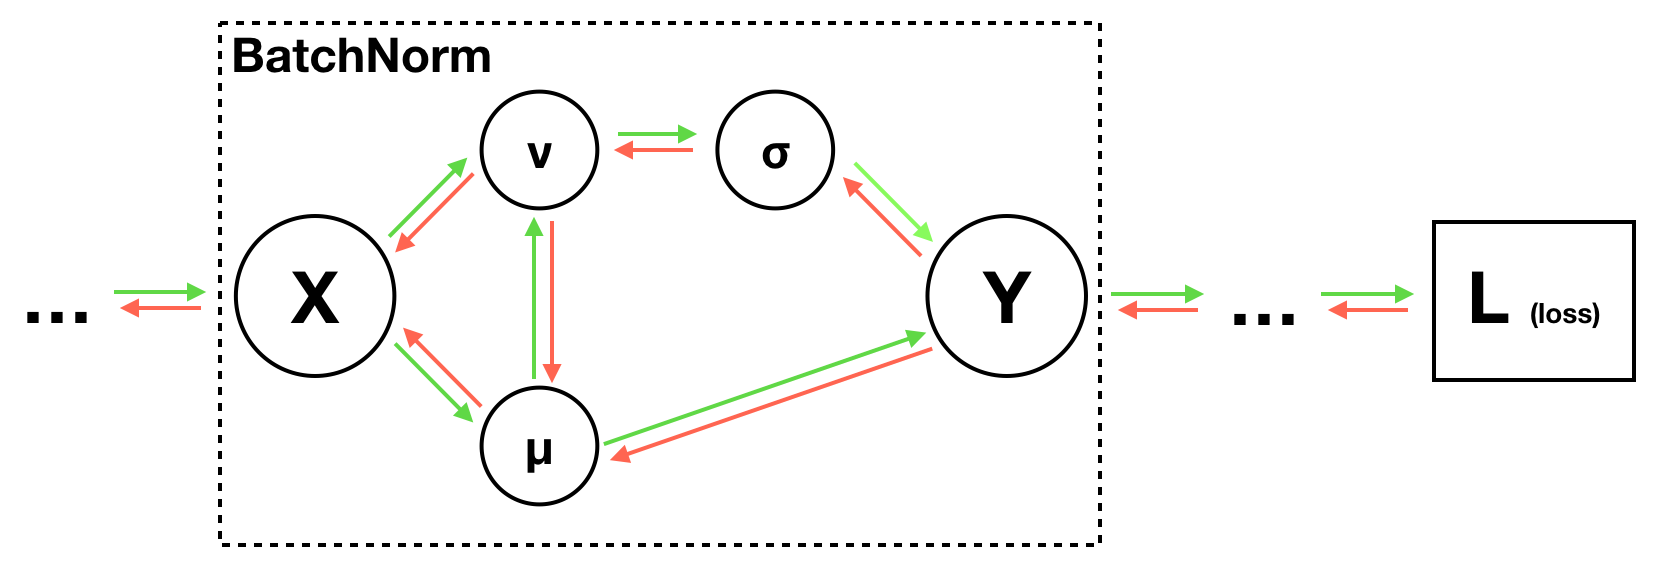

The meat of our problem during backpropagation is to compute $\frac{\partial L}{\partial X}$, given the upstream gradient we receive, $\frac{\partial L}{\partial Y}.$ To do this, recall the chain rule in calculus gives us $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot \frac{\partial Y}{\partial X}$.

The unknown/hart part is $\frac{\partial Y}{\partial X}$. We can find this by first deriving step-by-step our local gradients at
$\frac{\partial v}{\partial X}$, $\frac{\partial \mu}{\partial X}$,
$\frac{\partial \sigma}{\partial v}$,
$\frac{\partial Y}{\partial \sigma}$, and $\frac{\partial Y}{\partial \mu}$,
and then use the chain rule to compose these gradients (which appear in the form of vectors!) appropriately to compute $\frac{\partial Y}{\partial X}$.

If it's challenging to directly reason about the gradients over $X$ and $Y$ which require matrix multiplication, try reasoning about the gradients in terms of individual elements $x_i$ and $y_i$ first: in that case, you will need to come up with the derivations for $\frac{\partial L}{\partial x_i}$, by relying on the Chain Rule to first calculate the intermediate $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ then assemble these pieces to calculate $\frac{\partial y_i}{\partial x_i}$.

You should make sure each of the intermediary gradient derivations are all as simplified as possible, for ease of implementation.

After doing so, implement the simplified batch normalization backward pass in the function `BatchNorm.backward_alt` and compare the two implementations by running the following. Your two implementations should compute nearly identical results, but the alternative implementation should be a bit faster, around 1.1x to 4x.

In [ ]:
from convolutional_networks import BatchNorm

reset_seed(0)
N, D = 128, 2048
x = 5 * torch.randn(N, D, **to_double) + 12
gamma = torch.randn(D, **to_double)
beta = torch.randn(D, **to_double)
dout = torch.randn(N, D, **to_double)

bn_param = {'mode': 'train'}
out, cache = BatchNorm.forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = BatchNorm.backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = BatchNorm.backward_alt(dout, cache)
t3 = time.time()

print('dx difference:', rel_error(dx1, dx2))
print('dgamma difference:', rel_error(dgamma1, dgamma2))
print('dbeta difference:', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

# Spatial Batch Normalization
As proposed in the original paper, batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Note that batch normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect every feature channel's statistics (mean and variance) to be relatively consistent not only between different images, but also different locations within the same image -- after all, every feature channel is produced by the same convolutional filter! Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over the minibatch dimension `N` as well the spatial dimensions `H` and `W`.


[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

## Spatial batch normalization: forward

Implement the forward pass for spatial batch normalization in the function `SpatialBatchNorm.forward`. Check your implementation by running the following:


After implementing the forward pass for spatial batch normalization, you can run the following to sanity check your code.

In [ ]:
from convolutional_networks import SpatialBatchNorm

reset_seed(0)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * torch.randn(N, C, H, W, **to_double) + 10

print('Before spatial batch normalization:')
print('  Shape:', x.shape)
print('  Means:', x.mean(dim=(0, 2, 3)))
print('  Stds:', x.std(dim=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma = torch.ones(C, **to_double)
beta = torch.zeros(C,**to_double)
bn_param = {'mode': 'train'}
out, _ = SpatialBatchNorm.forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (gamma=1, beta=0)')

print('  Shape:', out.shape)
print('  Means:', out.mean(dim=(0, 2, 3)))
print('  Stds :', out.std(dim=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma = torch.tensor([3, 4, 5], **to_double)
beta = torch.tensor([6, 7, 8], **to_double)
out, _ = SpatialBatchNorm.forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (gamma=', gamma.tolist(),
      ', beta=', beta.tolist(), ')')
print('  Shape:', out.shape)
print('  Means:', out.mean(dim=(0, 2, 3)))
print('  Stds :', out.std(dim=(0, 2, 3)))

Similar to the vanilla batch normalization implementation, run the following to sanity-check the test-time forward pass of spatial batch normalization.

In [ ]:
from convolutional_networks import SpatialBatchNorm

reset_seed(0)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = torch.ones(C, **to_double)
beta = torch.zeros(C, **to_double)
for t in range(50):
    x = 2.3 * torch.randn(N, C, H, W, **to_double) + 13
    SpatialBatchNorm.forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * torch.randn(N, C, H, W, **to_double) + 13
a_norm, _ = SpatialBatchNorm.forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  Means:', a_norm.mean(dim=(0, 2, 3)))
print('  Stds :', a_norm.std(dim=(0, 2, 3)))

## Spatial batch normalization: backward
Implement the backward pass for spatial batch normalization in the function `SpatialBatchNorm.backward`.

After implementing the backward pass for spatial batch normalization, run the following to perform numeric gradient checking on your implementation. You should see errors less than `1e-6`.

In [ ]:
from convolutional_networks import SpatialBatchNorm

reset_seed(0)
N, C, H, W = 2, 3, 4, 5
x = 5 * torch.randn(N, C, H, W, **to_double) + 12
gamma = torch.randn(C, **to_double)
beta = torch.randn(C, **to_double)
dout = torch.randn(N, C, H, W, **to_double)

bn_param = {'mode': 'train'}
fx = lambda x: SpatialBatchNorm.forward(x, gamma, beta, bn_param)[0]
fg = lambda a: SpatialBatchNorm.forward(x, gamma, beta, bn_param)[0]
fb = lambda b: SpatialBatchNorm.forward(x, gamma, beta, bn_param)[0]

dx_num = compute_numeric_gradient(fx, x, dout)
da_num = compute_numeric_gradient(fg, gamma, dout)
db_num = compute_numeric_gradient(fb, beta, dout)

_, cache = SpatialBatchNorm.forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = SpatialBatchNorm.backward(dout, cache)
print('dx error:', rel_error(dx_num, dx))
print('dgamma error:', rel_error(da_num, dgamma))
print('dbeta error:', rel_error(db_num, dbeta))

## "Sandwich" layers with batch normalization
Again, below you will find sandwich layers that implement a few commonly used patterns for convolutional networks. We include the functions in `convolutional_networks.py` but you can see them here for your convenience.

```python
class Linear_BatchNorm_ReLU(object):

    @staticmethod
    def forward(x, w, b, gamma, beta, bn_param):
        """
        Convenience layer that performs an linear transform, batch normalization,
        and ReLU.
        Inputs:
        - x: Array of shape (N, D1); input to the linear layer
        - w, b: Arrays of shape (D2, D2) and (D2,) giving the weight and bias for
        the linear transform.
        - gamma, beta: Arrays of shape (D2,) and (D2,) giving scale and shift
        parameters for batch normalization.
        - bn_param: Dictionary of parameters for batch normalization.
        Returns:
        - out: Output from ReLU, of shape (N, D2)
        - cache: Object to give to the backward pass.
        """
        a, fc_cache = Linear.forward(x, w, b)
        a_bn, bn_cache = BatchNorm.forward(a, gamma, beta, bn_param)
        out, relu_cache = ReLU.forward(a_bn)
        cache = (fc_cache, bn_cache, relu_cache)
        return out, cache

    @staticmethod
    def backward(dout, cache):
        """
        Backward pass for the linear-batchnorm-relu convenience layer.
        """
        fc_cache, bn_cache, relu_cache = cache
        da_bn = ReLU.backward(dout, relu_cache)
        da, dgamma, dbeta = BatchNorm.backward(da_bn, bn_cache)
        dx, dw, db = Linear.backward(da, fc_cache)
        return dx, dw, db, dgamma, dbeta


class Conv_BatchNorm_ReLU(object):

    @staticmethod
    def forward(x, w, b, gamma, beta, conv_param, bn_param):
        a, conv_cache = FastConv.forward(x, w, b, conv_param)
        an, bn_cache = SpatialBatchNorm.forward(a, gamma, beta, bn_param)
        out, relu_cache = ReLU.forward(an)
        cache = (conv_cache, bn_cache, relu_cache)
        return out, cache

    @staticmethod
    def backward(dout, cache):
        conv_cache, bn_cache, relu_cache = cache
        dan = ReLU.backward(dout, relu_cache)
        da, dgamma, dbeta = SpatialBatchNorm.backward(dan, bn_cache)
        dx, dw, db = FastConv.backward(da, conv_cache)
        return dx, dw, db, dgamma, dbeta


class Conv_BatchNorm_ReLU_Pool(object):

    @staticmethod
    def forward(x, w, b, gamma, beta, conv_param, bn_param, pool_param):
        a, conv_cache = FastConv.forward(x, w, b, conv_param)
        an, bn_cache = SpatialBatchNorm.forward(a, gamma, beta, bn_param)
        s, relu_cache = ReLU.forward(an)
        out, pool_cache = FastMaxPool.forward(s, pool_param)
        cache = (conv_cache, bn_cache, relu_cache, pool_cache)
        return out, cache

    @staticmethod
    def backward(dout, cache):
        conv_cache, bn_cache, relu_cache, pool_cache = cache
        ds = FastMaxPool.backward(dout, pool_cache)
        dan = ReLU.backward(ds, relu_cache)
        da, dgamma, dbeta = SpatialBatchNorm.backward(dan, bn_cache)
        dx, dw, db = FastConv.backward(da, conv_cache)
        return dx, dw, db, dgamma, dbeta
```


## Convolutional nets with batch normalization
Now that you have implemented batch normalization, go back to your `DeepConvnet`. Modify your implementation to add batch normalization.

Concretely, when the `batchnorm` flag is set to `True` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last linear layer of the network should not be normalized.
Again, we **STRONGLY** recommend you to use the fast/sandwich layers (already implemented for you) in your implementation.
Once you are done, run the following to gradient-check your implementation.

In the `reg=0` case, you should see errors less than `1e-5` for all weights and batchnorm parameters (beta and gamma); for biases, you might see high relative errors due to the extremely small magnitude of both numeric and analytic gradients, which is fine.

In the `reg=3.14` case, you should see errors less than `1e-5` for all parameters.

In [ ]:
from convolutional_networks import DeepConvNet

reset_seed(0)

num_inputs = 2
input_dims = (3, 8, 8)
num_classes = 10
X = torch.randn(num_inputs, *input_dims, **to_double)
y = torch.randint(num_classes, size=(num_inputs,), **to_long)

for reg in [0, 3.14]:
    print('Running check with reg =', reg)
    model = DeepConvNet(input_dims=input_dims, num_classes=num_classes,
                        num_filters=[8, 8, 8],
                        max_pools=[0, 2],
                        reg=reg, batchnorm=True,
                        weight_scale='kaiming',
                        **to_double)

    loss, grads = model.loss(X, y)

    for param_name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = compute_numeric_gradient(f, model.params[param_name])
        print('%s max relative error: %e' % (param_name, rel_error(grad_num, grads[param_name])))
    print()

## Batchnorm for deep convolutional networks
Run the following to train a deep convolutional network on a subset of 500 training examples both with and without batch normalization.

In [ ]:
from convolutional_networks import DeepConvNet
from fully_connected_networks import adam

reset_seed(0)

# Try training a deep convolutional net with batchnorm
num_train = 500
small_data = {
    'X_train': data_dict['X_train'][:num_train],
    'y_train': data_dict['y_train'][:num_train],
    'X_val': data_dict['X_val'],
    'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

bn_model = DeepConvNet(input_dims=input_dims, num_classes=10,
                       num_filters=[16, 32, 32, 64, 64],
                       max_pools=[0, 1, 2, 3, 4],
                       weight_scale='kaiming',
                       batchnorm=True,
                       reg=1e-5,  **to_float)
model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[16, 32, 32, 64, 64],
                    max_pools=[0, 1, 2, 3, 4],
                    weight_scale='kaiming',
                    batchnorm=False,
                    reg=1e-5,  **to_float)

print('Solver with batchnorm:')
bn_solver = Solver(bn_model, small_data,
                   num_epochs=10, batch_size=100,
                   update_rule=adam,
                   optim_config={
                     'learning_rate': 1e-3,
                   },
                   print_every=20, device='cuda')
bn_solver.train()

print('\nSolver without batchnorm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=100,
                update_rule=adam,
                optim_config={
                  'learning_rate': 1e-3,
                },
                print_every=20, device='cuda')
solver.train()

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

In [ ]:
def plot_training_history_bn(title, label, solvers, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plots = [plot_fn(solver) for solver in solvers]
    num_bn = len(bn_plots)
    num_bl = len(bl_plots)
    for i in range(num_bn):
        label='w/ BN'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    for i in range(num_bl):
        label='w/o BN'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bl_plots[i], bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+num_bl)

plt.subplot(3, 1, 1)
plot_training_history_bn('Training loss','Iteration', [solver], [bn_solver], \
                      lambda x: x.loss_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 2)
plot_training_history_bn('Training accuracy','Epoch', [solver], [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history_bn('Validation accuracy','Epoch', [solver], [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 25)
plt.show()

## Batch normalization and learning rate
We will now run a small experiment to study the interaction of batch normalization and learning rate.

The first cell will train convolutional networks with different learning rates, and the second cell will plot training accuracy and validation set accuracy over time. You should find that using batch normalization helps the network to be less dependent to the learning rate.

In [ ]:
from convolutional_networks import DeepConvNet
from fully_connected_networks import adam

reset_seed(0)

# Try training a very deep net with batchnorm
num_train = 5000
small_data = {
    'X_train': data_dict['X_train'][:num_train],
    'y_train': data_dict['y_train'][:num_train],
    'X_val': data_dict['X_val'],
    'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]
num_epochs = 5
lrs = [2e-3, 5e-3, 1e-2]

solvers = []
for lr in lrs:
    print('No normalization: learning rate =', lr)
    model = DeepConvNet(input_dims=input_dims, num_classes=10,
                        num_filters=[8, 8, 8, 8, 8, 8, 8],
                        max_pools=[0, 2, 4, 6],
                        weight_scale='kaiming',
                        batchnorm=False,
                        reg=1e-4, **to_float)
    solver = Solver(model, small_data,
                    num_epochs=num_epochs, batch_size=100,
                    update_rule=adam,
                    optim_config={
                    'learning_rate': lr,
                    },
                    verbose=False, device='cuda')
    solver.train()
    solvers.append(solver)

bn_solvers = []
for lr in lrs:
    print('Normalization: learning rate =', lr)
    bn_model = DeepConvNet(input_dims=input_dims, num_classes=10,
                            num_filters=[8, 8, 8, 8, 8, 8, 8],
                            max_pools=[0, 2, 4, 6],
                            weight_scale='kaiming',
                            batchnorm=True,
                            reg=1e-4, **to_float)
    bn_solver = Solver(bn_model, small_data,
                        num_epochs=num_epochs, batch_size=100,
                        update_rule=adam,
                        optim_config={
                        'learning_rate': lr,
                        },
                        verbose=False, device='cuda')
    bn_solver.train()
    bn_solvers.append(bn_solver)

In [ ]:
plt.subplot(2, 1, 1)
plot_training_history_bn('Training accuracy (Batch Normalization)','Epoch', solvers, bn_solvers, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in lrs])
plt.subplot(2, 1, 2)
plot_training_history_bn('Validation accuracy (Batch Normalization)','Epoch', solvers, bn_solvers, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in lrs])

plt.gcf().set_size_inches(10, 15)
plt.show()

# Submit Your Work
After completing the assignment, please check if all outputs are displayed properly and the outputs are same as what you expected.
Also, please check if you generated any additional cells and/or modified existing cells; you should not change them unless otherwise instructed with `TODO`.

Run the following cell to create a `.zip` file for you to download and turn in. Your change may not always be automatically saved, so **please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell.**

In particular, if you come here by *Run all* command, **please MANUALLY SAVE this notebook and execute the following cell again;** otherwise, the ipynb file in the zip might not contain the last few execution results.

In [ ]:
from common.submit import make_submission

make_submission(GOOGLE_DRIVE_PATH, 3, name, idnum)